In [1]:
import tensorflow as tf
print(tf.__version__)  # should be 2.15.0
print(tf.config.list_physical_devices('GPU'))  # should list GPU


2025-05-18 21:16:34.481601: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-18 21:16:34.481655: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-18 21:16:34.482803: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 🧽 Warning Suppression

To maintain a clean output and avoid cluttering the notebook with non-critical warnings (e.g., future deprecations), we suppress all warnings using Python's built-in `warnings` module:

```python
import warnings
warnings.filterwarnings('ignore')


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import importlib
import utilities  

importlib.reload(utilities)


<module 'utilities' from '/home/jovyan/files/utilities.py'>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from datetime import datetime,timedelta
import requests
import ta
import base64
from cryptography.hazmat.primitives import serialization
from cryptography.hazmat.backends import default_backend
from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine
from sqlalchemy import text
import networkx as nx


In [5]:
import os
from dotenv import load_dotenv

load_dotenv()

True

# Snowflake Connection


In [6]:
with open(os.getenv("PRIVATE_KEY_PATH"), "rb") as key_file:
    private_key = serialization.load_pem_private_key(
        key_file.read(),
        password=None,
        backend=default_backend()
    )

private_key_pkcs8 = base64.b64encode(
    private_key.private_bytes(
        encoding=serialization.Encoding.DER,
        format=serialization.PrivateFormat.PKCS8,
        encryption_algorithm=serialization.NoEncryption()
    )
).decode("utf-8")  # ✅ base64 string, not bytes!

engine = create_engine(URL(
    account=os.getenv("SNOWFLAKE_ACCOUNT"),
    user=os.getenv("SNOWFLAKE_USER"),
    private_key=private_key_pkcs8,
    warehouse=os.getenv("SNOWFLAKE_WAREHOUSE"),
    database=os.getenv("SNOWFLAKE_DATABASE"),
    schema=os.getenv("SNOWFLAKE_SCHEMA"),
    role=os.getenv("SNOWFLAKE_ROLE")
))

with engine.connect() as conn:
    result = conn.execute(text("SELECT CURRENT_USER(), CURRENT_ROLE(), CURRENT_TIMESTAMP();"))
    for row in result:
        print("✅ Snowflake connected:", row)


✅ Snowflake connected: ('CRYPTO_USER', 'CRYPTO_ROLE', datetime.datetime(2025, 5, 18, 14, 16, 40, 701000, tzinfo=<DstTzInfo 'America/Los_Angeles' PDT-1 day, 17:00:00 DST>))


In [7]:
from datetime import datetime

execution_time = datetime.now().strftime("%Y%m%d%H%M%S")

# Reading assets file

In [8]:
top100 = pd.read_csv('Assets_Categorized.csv')

In [9]:
top100['staging'] = '@cryptodatasource'
top100.drop(columns=['realticker'],inplace=True)


### 🗂️ Incremental Data Ingestion from Yahoo Finance

This section ensures that price data for the top 100 tickers is **up-to-date**, downloading only the missing historical records and storing them into a Snowflake staging area.

#### **Logic Breakdown**
- **Latest Date Check**: For each ticker, the script queries the latest available date from the `VW_CRYPTO` view in Snowflake.
- **Smart Start Date**: If no data exists, it defaults to `2019-01-01`. Otherwise, it starts from the next day after the most recent entry.
- **Skip Up-to-Date Tickers**: If the latest date is today or later, the ticker is skipped to avoid redundant downloads.
- **Download Missing Data**: For all other cases, the `download_yahoo_to_stage()` utility fetches historical daily prices from Yahoo Finance and stages them.

#### **Why This Matters**
- Ensures efficient **delta loading** — no unnecessary API calls or overwrites.
- Maintains **data freshness** for modeling and clustering without full reprocessing.
- Reduces compute costs and network traffic by avoiding full dataset reloads.

> ⚙️ This incremental ingestion design is perfect for **automated daily jobs** (e.g., via Airflow or dbt) and supports long-term project scalability.


In [10]:
# from utilities import download_yahoo_to_stage

# now = datetime(datetime.now().year,datetime.now().month,datetime.now().day)
# start_date = datetime(2019, 1, 1)

# for index, row in top100.iterrows():
#     query = text("SELECT coalesce(dateadd(day,1,MAX(date)),'2019-01-01') as date FROM PUBLIC.VW_CRYPTO WHERE ticker = :ticker ")
#     df_date = pd.read_sql(query, con=engine, params={"ticker": row['ticker']})
#     start_date = pd.to_datetime(df_date['date'].iloc[0])
     
#     if start_date > now:
#         print(f"✅ {row['ticker']}: Up to date — skipping download.")
#     else:
#         # Download only what’s missing
#         download_yahoo_to_stage(
#             ticker=row['ticker'],
#             private_key=private_key,
#             stage_area=row['staging'],
#             interval="1d",
#             start=start_date,
#             time="12:00 AM",
#             execution_time=execution_time
#         )


### 🧹 Data Loading & Cleaning: OHLCV Time Series

This step loads the OHLCV (Open, High, Low, Close, Volume) price data for crypto tickers from Snowflake and applies a multi-step cleaning process to ensure consistency across the dataset.

---

#### **Step 1: Load & Filter**
- SQL query pulls price data from `VW_CRYPTO` starting from `2020-01-01`.
- Filters out **stablecoins** (non-volatile by design) to focus on more predictive assets.
- Merges with the `top100` metadata to bring in staging/category info.

#### **Step 2: Missing Value Handling**
Each OHLCV column is cleaned with a **multi-stage imputation** strategy:
1. **Forward-fill** (fill with previous known value)
2. **Backward-fill** (fill with next known value)
3. **Fill with per-ticker mean** if still missing

This preserves temporal continuity and avoids dropping valuable rows due to sparsity.

#### **Step 3: Pivot to Close Price Matrix**
- A matrix of close prices is created (`price_df`), with:
  - **Rows** = Dates
  - **Columns** = Tickers
  - **Values** = Closing prices

#### **Step 4: Final Cleanup**
- Any remaining NaNs in `price_df` (likely isolated values) are filled with the **average close price** for that ticker.
- A final NaN check is performed and printed to validate the dataset is ready for analysis.

---

> 📌 This data wrangling stage ensures a **complete and consistent** dataset — a critical foundation for accurate clustering, modeling, and evaluation.


In [11]:
from sqlalchemy import text
import pandas as pd
import numpy as np

# Step 1: Load and merge
query = text("""
    SELECT DISTINCT date, open,high,low,close, volume, ticker
    FROM PUBLIC.VW_CRYPTO
    WHERE date >= '2020-01-01'
    and ticker in ( select distinct ticker from vw_crypto where date <='2020-01-01')
    ORDER BY ticker, date
""")
data = pd.read_sql(query, con=engine)
data.drop_duplicates(['date', 'ticker'], keep='last', inplace=True)

data = pd.merge(data, top100, on='ticker', how='left')
data = data[data['category'] != 'Stablecoin']

print("✅ Loaded data for tickers:", data['ticker'].nunique())


ohlcv_cols = ['open', 'high', 'low', 'close', 'volume']
data = data.sort_values(by=['ticker', 'date'])

for col in ohlcv_cols:
    # Fill forward, then backward, then with mean (per ticker)
    data[col] = (
        data.groupby('ticker')[col]
        .apply(lambda grp: grp.ffill().bfill().fillna(grp.mean()))
        .reset_index(level=0, drop=True)
    )

nan_summary = data[ohlcv_cols].isna().sum()
print("🧹 Still NaNs in `data` (should be 0):")
print(nan_summary[nan_summary > 0])


# Step 2: Pivot close prices
price_df = data.pivot(index='date', columns='ticker', values='close')

# b. Fill remaining NaNs with the average of the column
price_df = price_df.apply(lambda col: col.fillna(col.mean()), axis=0)

# Step 4: Optional check
nan_summary = price_df.isna().sum()
print("🧹 Still NaN per ticker (should be 0):")
print(nan_summary[nan_summary > 0])





✅ Loaded data for tickers: 142
🧹 Still NaNs in `data` (should be 0):
Series([], dtype: int64)
🧹 Still NaN per ticker (should be 0):
Series([], dtype: int64)


### 📊 Asset Selection and Distance Matrix Calculation

This section prepares the dataset for network analysis by selecting a representative set of assets based on data availability and domain relevance. Here's the breakdown:

- **Top N assets by data availability**: We begin by selecting the top `80` tickers with the highest number of non-null price entries to ensure consistent historical coverage.
- **Manually enforced assets**: To ensure that key assets are always included — even if they have sparse data — we manually add important tickers such as:
  - Major cryptocurrencies (`BTC-USD`, `ETH-USD`)
  - Commodities (`GC=F` for gold, `SI=F` for silver)
  - Market indices (`^GSPC`, `^NDX`)
  - Volatility index (`^VIX`)
  - BTC conversions to major fiat currencies (`BTC-RUB`, `BTC-GBP`, `BTC-CNY`, `BTC-INR`)
- **Data cleaning**: Zero values are treated as missing and replaced with `NaN`.
- **Return calculation**: Logarithmic returns are computed to capture percentage changes and normalize across different asset price ranges.
- **Correlation & distance matrices**: A Pearson correlation matrix is computed on returns, followed by transformation into a distance matrix using the formula:  
  \[
  d(i, j) = \sqrt{2(1 - \rho(i, j))}
  \]  
  This metric satisfies the triangle inequality and is suitable for network-based clustering.


In [12]:
topN = 100
required_tickers = ['BTC-USD', 'ETH-USD','GC=F','SI=F','^GSPC','^NDX','BTC-RUB','BTC-GBP','BTC-CNY','BTC-INR','^VIX']

top_tickers = price_df.notna().sum().sort_values(ascending=False).head(topN).index.tolist()

for ticker in required_tickers:
    if ticker not in top_tickers and ticker in price_df.columns:
        top_tickers.append(ticker)

top_tickers = list(dict.fromkeys(top_tickers))

filtered_price_df = price_df[top_tickers]

cleaned_prices = filtered_price_df.replace(0, np.nan)
returns = np.log(cleaned_prices / cleaned_prices.shift(1)).dropna()

corr_matrix = returns.corr()
distance_matrix = np.sqrt(2 * (1 - corr_matrix))

In [13]:
corr_matrix.head()

ticker,AAPL,OKB-USD,MU,NEXO-USD,NFLX,NVDA,NXPI,ODFL,ON,MSFT,...,ADI,ADP,ADSK,AEP,ALGO-USD,AMD,AVGO,ETH-USD,GC=F,^VIX
ticker,,,,,,,,,,,,,,,,,,,,,
AAPL,1.000000,-0.015088,0.748663,-0.011155,0.467836,0.876114,0.874914,0.920707,0.818838,0.941943,...,0.939180,0.893379,0.438159,0.671522,0.017653,0.825531,0.902417,-0.000105,0.747230,-0.491016
OKB-USD,-0.015088,1.000000,0.000424,0.465938,0.017328,-0.004174,-0.001710,-0.011619,-0.006584,-0.002514,...,-0.006229,-0.003376,0.026946,-0.014047,0.480124,0.001270,-0.006640,0.553201,-0.017194,-0.060386
MU,0.748663,0.000424,1.000000,0.021213,0.606963,0.767535,0.896449,0.714138,0.581751,0.832340,...,0.820473,0.661561,0.552225,0.406077,0.045104,0.822630,0.769710,0.036656,0.619804,-0.613969
NEXO-USD,-0.011155,0.465938,0.021213,1.000000,0.047443,-0.006622,0.004110,-0.011469,-0.025185,0.001300,...,-0.004233,-0.023403,0.054041,-0.024065,0.563010,0.008595,-0.005909,0.701417,0.014258,-0.072355
NFLX,0.467836,0.017328,0.606963,0.047443,1.000000,0.655296,0.477326,0.386919,0.060422,0.584263,...,0.486781,0.371831,0.726177,0.201716,0.030901,0.516631,0.611137,0.013718,0.705537,-0.358963


### 🌐 Network Construction and Centrality Analysis

This section builds a network of financial instruments based on their pairwise distances and extracts key structural insights through graph theory techniques.

#### **Step 1: Distance Matrix Cleaning**
- Rows and columns with any missing values are removed from the distance matrix to ensure a fully connected graph.

#### **Step 2: Undirected Graph Construction**
- An undirected graph `G` is initialized using `networkx`.
- **Nodes** represent individual tickers (assets).
- **Edges** represent the distance between asset return correlations, with weights derived from the cleaned distance matrix.

#### **Step 3: Minimum Spanning Tree (MST)**
- To simplify the network and retain its essential structure, a **Minimum Spanning Tree** is computed.
- The MST ensures the graph is connected using the shortest total distance without forming cycles, which is particularly useful for financial network analysis and clustering.

#### **Step 4: Centrality Measures**
- Several centrality metrics are calculated on the MST to identify influential or central assets:
  - **Degree centrality**: Number of direct connections.
  - **Betweenness centrality**: How often a node acts as a bridge on the shortest path between others.
  - **Closeness centrality**: Inverse of the average distance to all other nodes.
  - **Eigenvector centrality**: Measures influence by considering the centrality of a node’s neighbors (computed with the robust NumPy method).

#### **Step 5: Centrality Summary**
- All centrality scores are stored in a single DataFrame for further analysis.
- Assets are ranked by **eigenvector centrality** to identify the most influential nodes in the financial network.


In [14]:



# Clean the distance matrix
clean_distance = distance_matrix.dropna(axis=0, how='any').dropna(axis=1, how='any')

# Step 1: Create an undirected graph
G = nx.Graph()

# Add nodes (tickers)
for ticker in clean_distance.columns:
    G.add_node(ticker)

# Add edges with weights (distances)
for i in range(len(clean_distance.columns)):
    for j in range(i + 1, len(clean_distance.columns)):
        t1 = clean_distance.columns[i]
        t2 = clean_distance.columns[j]
        dist = clean_distance.iloc[i, j]
        if pd.notnull(dist):
            G.add_edge(t1, t2, weight=dist)

# Step 2: Create Minimum Spanning Tree (MST)
mst = nx.minimum_spanning_tree(G)

# Step 3: Calculate centrality metrics (using eigenvector_centrality_numpy)
centrality = {
    'degree': nx.degree_centrality(mst),
    'betweenness': nx.betweenness_centrality(mst),
    'closeness': nx.closeness_centrality(mst),
    'eigenvector': nx.eigenvector_centrality_numpy(mst)  # <-- numpy method (robust)
}

# Combine into a DataFrame
centrality_df = pd.DataFrame(centrality)

# Preview top nodes by eigenvector centrality
print(centrality_df.sort_values(by='eigenvector', ascending=False).head())


            degree  betweenness  closeness  eigenvector
ETH-USD   0.088235     0.421277   0.134387     0.628484
BTC-USD   0.049020     0.426713   0.144068     0.328915
LINK-USD  0.029412     0.147350   0.120853     0.255532
LTC-USD   0.029412     0.076878   0.119718     0.242776
BNB-USD   0.029412     0.039022   0.119159     0.236970


In [15]:
print(f"Total nodes in MST: {len(mst.nodes())}")
print(f"Total edges in MST: {len(mst.edges())}")


Total nodes in MST: 103
Total edges in MST: 102


In [16]:
centrality_df.head()

,degree,betweenness,closeness,eigenvector
AAPL,0.009804,0.0,0.136182,0.000517
OKB-USD,0.009804,0.0,0.106583,0.072584
MU,0.009804,0.0,0.119438,0.000172
NEXO-USD,0.009804,0.0,0.118605,0.192505
NFLX,0.009804,0.0,0.137652,0.001297


### 🖼️ Minimum Spanning Tree Visualization

This section visualizes the financial network using the **Minimum Spanning Tree (MST)**, where node and edge aesthetics encode important graph-theoretic insights:

#### **Node Properties**
- **Size**: Proportional to **eigenvector centrality**, highlighting the most influential assets in the network.
- **Color**: Encodes **closeness centrality**, where warmer colors represent nodes that are, on average, closer to all other nodes (more central in the graph).
- A colorbar is added to interpret the centrality gradient.

#### **Edge Properties**
- **Width & Color**: Reflect the **inverse distance** (1 / distance) between connected assets, representing stronger correlations with bolder and more vivid edges.

#### **Layout & Aesthetics**
- The graph uses a **spring layout** for node positioning, which simulates physical repulsion and attraction forces to yield an intuitive spatial structure.
- Node labels identify each asset.
- Title and axis formatting improve readability, and the layout is adjusted for a clean presentation.

> 🔍 This MST visualization offers an intuitive overview of how closely assets are related in terms of return behavior, and highlights influential nodes based on centrality scores — useful for both exploratory analysis and downstream modeling.


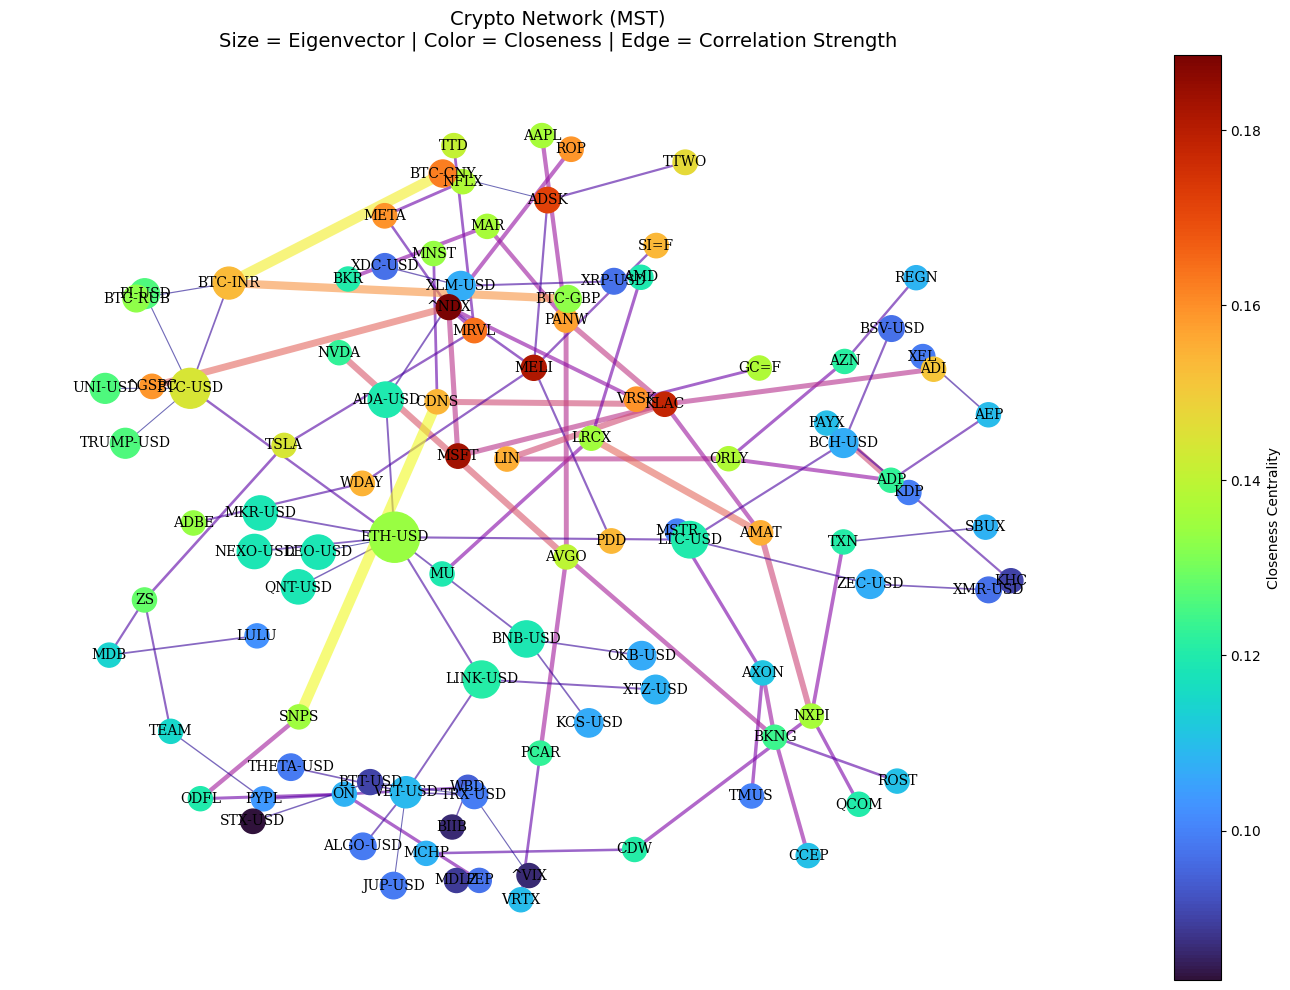

In [17]:


# Use spring layout for positioning
pos = nx.spring_layout(mst, seed=42, k=0.3)

# Centrality scores
eigen = centrality_df['eigenvector']
closeness = centrality_df['closeness']

# Normalize node sizes and colors
node_sizes = 1000 * (eigen - eigen.min()) / (eigen.max() - eigen.min()) + 300
norm_closeness = (closeness - closeness.min()) / (closeness.max() - closeness.min())

# Edge weights and colors based on inverse distance
edge_weights = [1 / mst[u][v]['weight'] for u, v in mst.edges()]
edge_colors = edge_weights

# Set up plot
fig, ax = plt.subplots(figsize=(14, 10))

# Draw nodes
nodes = nx.draw_networkx_nodes(
    mst, pos,
    node_size=node_sizes,
    node_color=norm_closeness,
    cmap=plt.cm.turbo,
    ax=ax
)

# Draw edges with color mapping
edges = nx.draw_networkx_edges(
    mst, pos,
    width=edge_weights,
    edge_color=edge_colors,
    edge_cmap=plt.cm.plasma,
    edge_vmin=min(edge_colors),
    edge_vmax=max(edge_colors),
    alpha=0.6,
    ax=ax
)

# Draw labels
nx.draw_networkx_labels(
    mst, pos,
    font_size=10,
    font_family='serif',
    ax=ax
)

# Highlight top eigenvector nodes
#top_n = eigen.sort_values(ascending=False).head(5).index
#for node in top_n:
#    x, y = pos[node]
#    ax.text(x, y + 0.05, f"[Top] {node}", fontsize=9, ha='center', color='gold')
    #ax.text(x, y + 0.05, f"⭐ {node}", fontsize=9, ha='center', color='gold')

# Add colorbar for node color
sm = plt.cm.ScalarMappable(cmap=plt.cm.turbo, norm=plt.Normalize(vmin=closeness.min(), vmax=closeness.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Closeness Centrality")

# Final formatting
ax.set_title("Crypto Network (MST)\nSize = Eigenvector | Color = Closeness | Edge = Correlation Strength", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()




In [18]:
filtered_price_df.head()

ticker,AAPL,OKB-USD,MU,NEXO-USD,NFLX,NVDA,NXPI,ODFL,ON,MSFT,...,ADI,ADP,ADSK,AEP,ALGO-USD,AMD,AVGO,ETH-USD,GC=F,^VIX
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,156.937516,2.621655,74.266997,0.097842,505.862612,44.146998,180.055197,148.704063,55.868949,296.553892,...,163.097014,209.926675,239.847424,81.378020,0.219938,103.825718,79.576302,130.802002,2014.110870,21.449874
2020-01-02,72.716080,2.548617,54.150455,0.105085,329.809998,5.972162,118.399147,62.628773,25.059999,153.323257,...,109.436234,152.393890,187.830002,77.261681,0.213518,49.099998,27.901751,127.410179,1524.500000,12.470000
2020-01-03,72.009132,2.645859,53.309708,0.107530,325.899994,5.876572,117.256996,61.881916,24.690001,151.414093,...,107.509750,152.071808,184.949997,77.179031,0.228098,48.599998,27.192068,134.171707,1549.199951,14.020000
2020-01-04,156.937516,2.662840,74.266997,0.114129,505.862612,44.146998,180.055197,148.704063,55.868949,296.553892,...,163.097014,209.926675,239.847424,81.378020,0.236382,103.825718,79.576302,135.069366,2014.110870,21.449874
2020-01-05,156.937516,2.680283,74.266997,0.116022,505.862612,44.146998,180.055197,148.704063,55.868949,296.553892,...,163.097014,209.926675,239.847424,81.378020,0.231657,103.825718,79.576302,136.276779,2014.110870,21.449874


In [19]:
from utilities import cluster_from_correlation

data.isna().sum()



date        0
open        0
high        0
low         0
close       0
volume      0
ticker      0
name        0
category    0
market      0
staging     0
dtype: int64

In [20]:
cluster_corr = cluster_from_correlation(data, k=4)
cluster_corr.head()

,ticker,cluster
0,AAPL,0
1,ADA-USD,0
2,ADBE,0
3,ADI,0
4,ADP,0


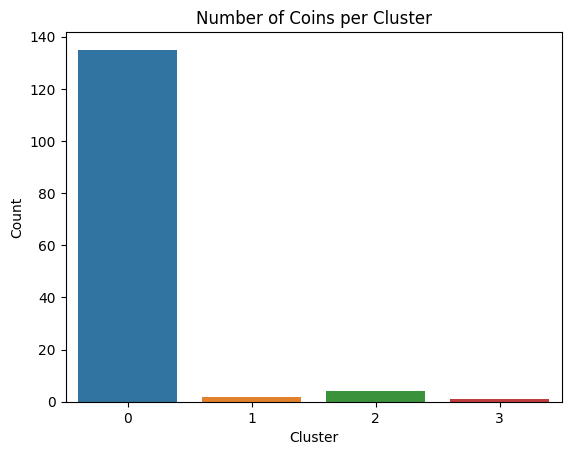

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=cluster_corr, x='cluster', palette='tab10')
plt.title('Number of Coins per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


In [22]:
btc_cluster = cluster_corr[cluster_corr['ticker']=='BTC-USD']['cluster'].values[0]

In [23]:
cluster_corr[cluster_corr['cluster']==btc_cluster]

,ticker,cluster
0,AAPL,0
1,ADA-USD,0
2,ADBE,0
3,ADI,0
4,ADP,0
...,...,...
136,XTZ-USD,0
137,ZEC-USD,0
138,ZS,0
139,^GSPC,0


### 🧠 Louvain Clustering for Community Detection

In this step, we apply **Louvain clustering** to detect communities of assets that exhibit high correlation in their return profiles.

#### **Key Concepts**
- **Graph construction**: A graph is built where nodes represent assets and edges connect assets with pairwise correlation above a given threshold (`min_corr = 0.7`).
- **Community detection**: The **Louvain method** is used to partition the graph into clusters (communities), maximizing **modularity**, which measures the density of connections within clusters versus between clusters.

#### **Function Output**
- `cluster_louvain`: A dictionary mapping each ticker to its Louvain cluster label.
- `G`: The correlation graph used for clustering.
- `clustered_returns`: A return matrix annotated with Louvain cluster labels, useful for downstream cluster-based modeling or visualization.

#### 🆚 Louvain vs. K-Means
- **K-Means** requires specifying the number of clusters (`k`) in advance and assumes spherical, equal-sized clusters based on Euclidean distance — which may not reflect real financial relationships.
- **Louvain** is **non-parametric**, automatically detects the number of clusters, and operates on a graph-based structure using correlation thresholds, making it more suitable for **networked financial systems** and **non-linear dependencies**.

> 📌 Plotting is enabled to visually inspect the modular structure and validate cluster cohesiveness.



✅ Tickers included after fill: ['AAPL', 'ADA-USD', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AEP', 'ALGO-USD', 'AMAT', 'AMD', 'AMGN', 'AMZN', 'ANSS', 'ARB-USD', 'ASML', 'ATOM-USD', 'AVGO', 'AXON', 'AZN', 'BCH-USD', 'BIIB', 'BKNG', 'BKR', 'BNB-USD', 'BSV-USD', 'BTC-CNY', 'BTC-GBP', 'BTC-INR', 'BTC-RUB', 'BTC-USD', 'BTT-USD', 'CCEP', 'CDNS', 'CDW', 'CHTR', 'CMCSA', 'COST', 'CPRT', 'CRO-USD', 'CRWD', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTSH', 'DDOG', 'DOGE-USD', 'DXCM', 'EA', 'EOS-USD', 'ETC-USD', 'ETH-USD', 'EXC', 'FANG', 'FAST', 'FET-USD', 'FIL-USD', 'FTNT', 'GC=F', 'GILD', 'GOOG', 'GOOGL', 'GT-USD', 'HBAR-USD', 'HON', 'IDXX', 'INTC', 'INTU', 'ISRG', 'JUP-USD', 'KCS-USD', 'KDP', 'KHC', 'KLAC', 'LEO-USD', 'LIN', 'LINK-USD', 'LRCX', 'LTC-USD', 'LULU', 'MAR', 'MCHP', 'MDB', 'MDLZ', 'MELI', 'META', 'MKR-USD', 'MNST', 'MRVL', 'MSFT', 'MSTR', 'MU', 'NEXO-USD', 'NFLX', 'NVDA', 'NXPI', 'ODFL', 'OKB-USD', 'ON', 'ORLY', 'PANW', 'PAYX', 'PCAR', 'PDD', 'PEP', 'PI-USD', 'PYPL', 'QCOM', 'QNT-USD', 'REGN', 'ROP', 'R

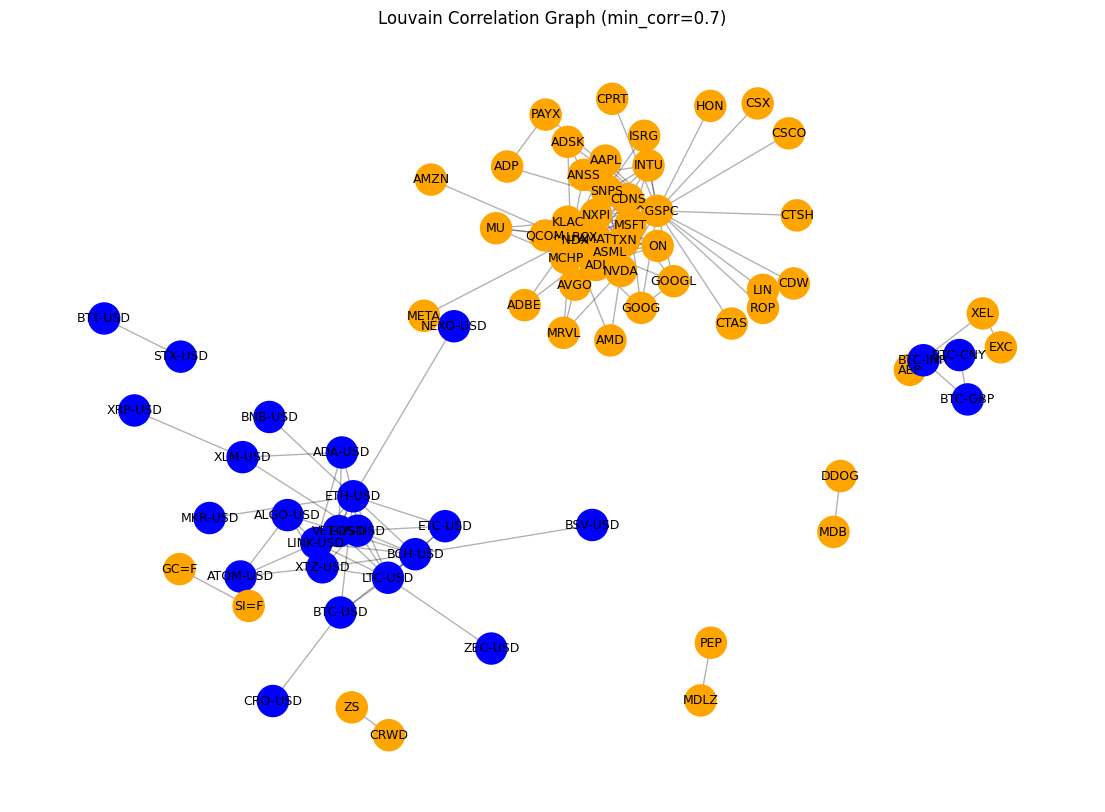

🪫 Unconnected tickers (65): ['AMGN', 'ARB-USD', 'AXON', 'AZN', 'BIIB', 'BKNG', 'BKR', 'BTC-RUB', 'CCEP', 'CHTR', 'CMCSA', 'COST', 'CSGP', 'DOGE-USD', 'DXCM', 'EA', 'FANG', 'FAST', 'FET-USD', 'FIL-USD', 'FTNT', 'GILD', 'GT-USD', 'HBAR-USD', 'IDXX', 'INTC', 'JUP-USD', 'KCS-USD', 'KDP', 'KHC', 'LEO-USD', 'LULU', 'MAR', 'MELI', 'MNST', 'MSTR', 'NFLX', 'ODFL', 'OKB-USD', 'ORLY', 'PANW', 'PCAR', 'PDD', 'PI-USD', 'PYPL', 'QNT-USD', 'REGN', 'ROST', 'SBUX', 'TEAM', 'THETA-USD', 'TMUS', 'TRUMP-USD', 'TRX-USD', 'TSLA', 'TTD', 'TTWO', 'UNI-USD', 'VRSK', 'VRTX', 'WBD', 'WDAY', 'XDC-USD', 'XMR-USD', '^VIX']


In [24]:
from utilities import louvain_from_returns
cluster_louvain,G,clustered_returns = louvain_from_returns(data, min_corr=0.7, plot=True)


In [25]:
cluster_louvain['ticker'].unique()

array(['AAPL', 'MSFT', '^GSPC', '^NDX', 'ADA-USD', 'ETH-USD', 'LINK-USD',
       'VET-USD', 'XLM-USD', 'ADBE', 'ADI', 'AMAT', 'ASML', 'KLAC',
       'LRCX', 'MCHP', 'NXPI', 'ON', 'QCOM', 'TXN', 'ADP', 'PAYX', 'ADSK',
       'ANSS', 'AEP', 'EXC', 'XEL', 'ALGO-USD', 'ATOM-USD', 'XTZ-USD',
       'AVGO', 'CDNS', 'MU', 'NVDA', 'SNPS', 'AMD', 'AMZN', 'INTU',
       'MRVL', 'BCH-USD', 'BSV-USD', 'BTC-USD', 'EOS-USD', 'ETC-USD',
       'LTC-USD', 'BNB-USD', 'BTC-CNY', 'BTC-GBP', 'BTC-INR', 'CRO-USD',
       'BTT-USD', 'STX-USD', 'CDW', 'CPRT', 'CRWD', 'ZS', 'CSCO', 'CSX',
       'CTAS', 'CTSH', 'DDOG', 'MDB', 'MKR-USD', 'NEXO-USD', 'GC=F',
       'SI=F', 'GOOG', 'GOOGL', 'HON', 'ISRG', 'LIN', 'ZEC-USD', 'MDLZ',
       'PEP', 'META', 'ROP', 'XRP-USD'], dtype=object)

### 📈 Technical Analysis Feature Engineering

This section enriches the BTC-USD dataset with **technical indicators** commonly used in financial analysis and trading strategies.

#### **Function: `technical_analysis()`**
This utility function computes and appends a range of technical indicators to the BTC dataframe, such as:

- **Momentum indicators**:  
  - *RSI (Relative Strength Index)*  
  - *MACD (Moving Average Convergence Divergence)*  
  - *Stochastic Oscillator*
- **Trend indicators**:  
  - *EMA (Exponential Moving Averages — Short and Long)*  
  - *SAR (Parabolic Stop and Reverse)*
- **Volatility indicators**:  
  - *Bollinger Bands*  
  - *ATR (Average True Range)* *(if included)*

These features are useful for supervised modeling and help capture price dynamics, trend strength, and potential reversal signals in BTC returns.

> ⚙️ This step is modular and can be extended to other tickers if needed. By default, the transformation is applied here to `BTC-USD` only.


In [26]:
from utilities import technical_analysis

btc_df = data[data['ticker'] == 'BTC-USD'].copy()
btc_df = technical_analysis(btc_df)

Technical Analysis function has been finished


### 🤝 Peer Discovery and Louvain Cluster Visualization

This section identifies BTC's cluster peers and visually explores the modular structure of the financial network based on Louvain clustering.

#### **BTC-Centric Cluster Extraction**
- We first determine the **Louvain cluster** to which `BTC-USD` belongs.
- All other tickers in the same cluster are considered **BTC's peer assets** — these are assumed to exhibit high correlation and belong to the same structural community.

#### **Peer Price Matrix**
- Price data for the peer tickers is extracted and **pivoted** into a matrix format (`date` as index, tickers as columns) to enable downstream modeling or correlation analysis.

#### **Cluster Visualization**
- For **each Louvain cluster**, we:
  - Extract the corresponding subgraph from the full correlation network.
  - Plot it using a spring layout for clear separation and structure.
  - Skip singleton clusters (only one node, no edges).
- This helps us visually validate:
  - The density and cohesion of individual clusters.
  - Whether BTC's cluster appears tightly connected or dispersed.

> 📌 This visualization bridges the gap between network theory and financial intuition — helping to validate and interpret cluster assignments based on return behavior.


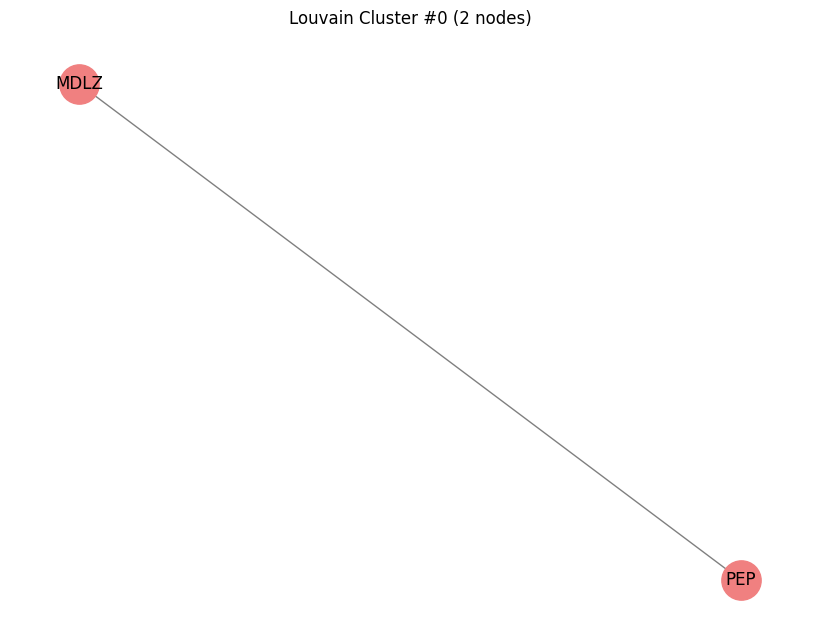

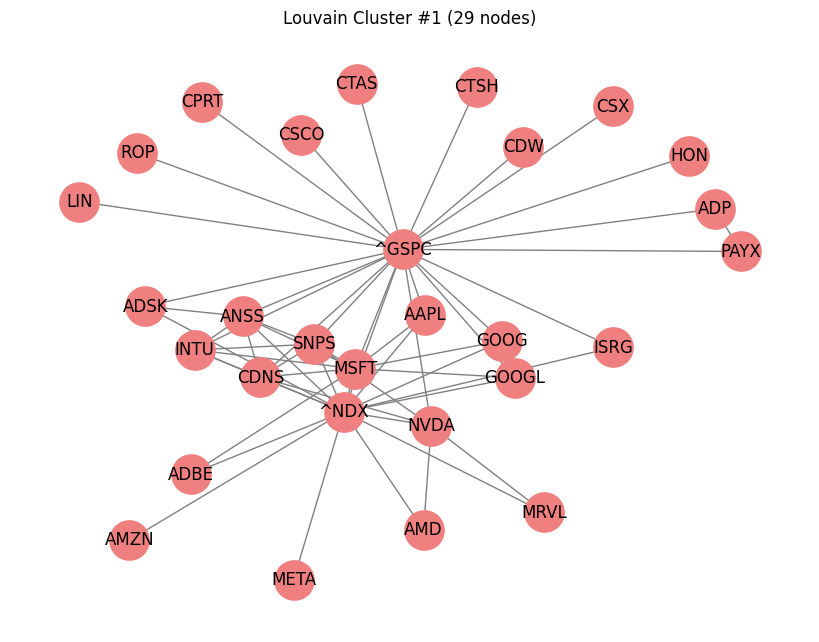

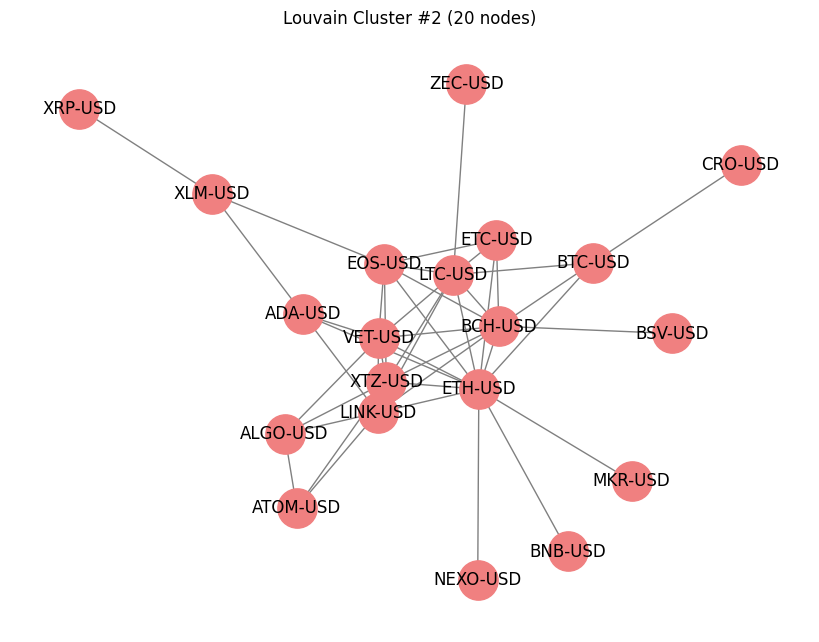

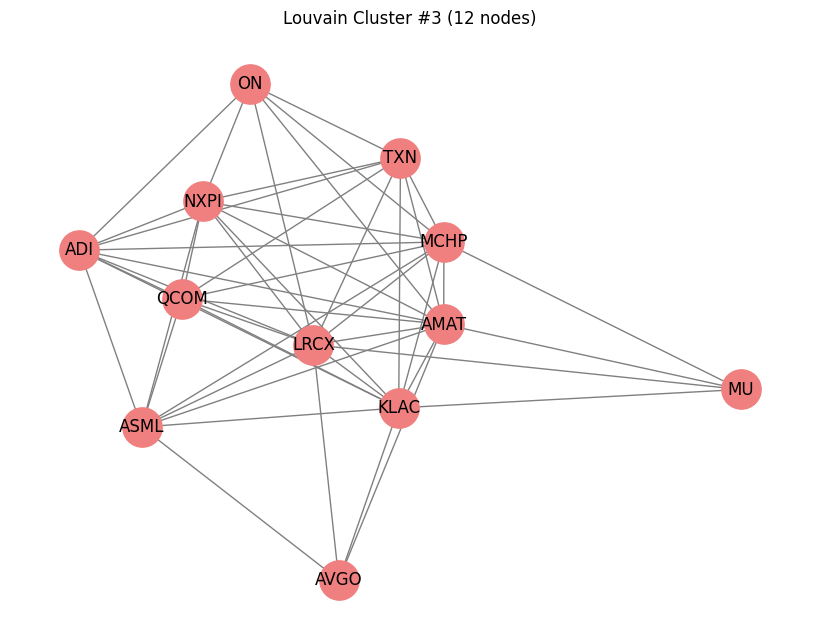

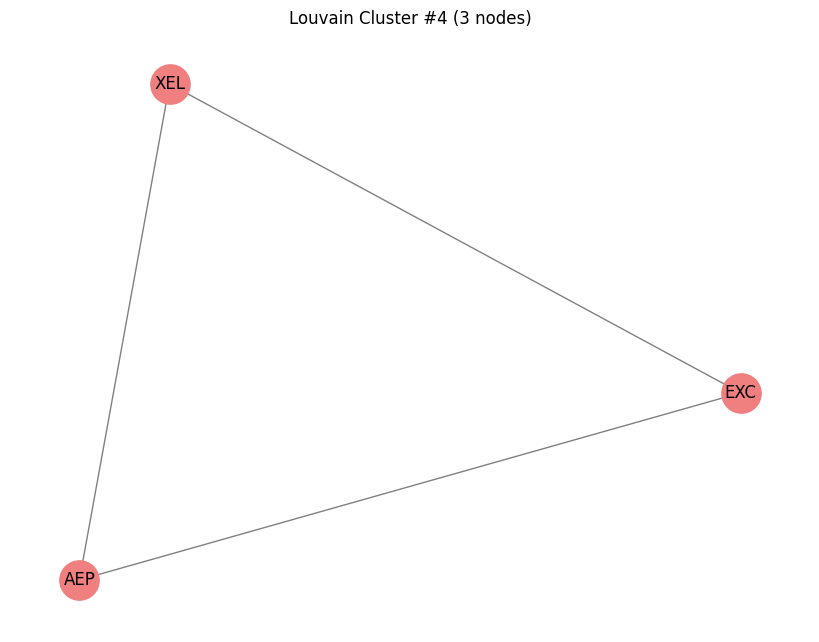

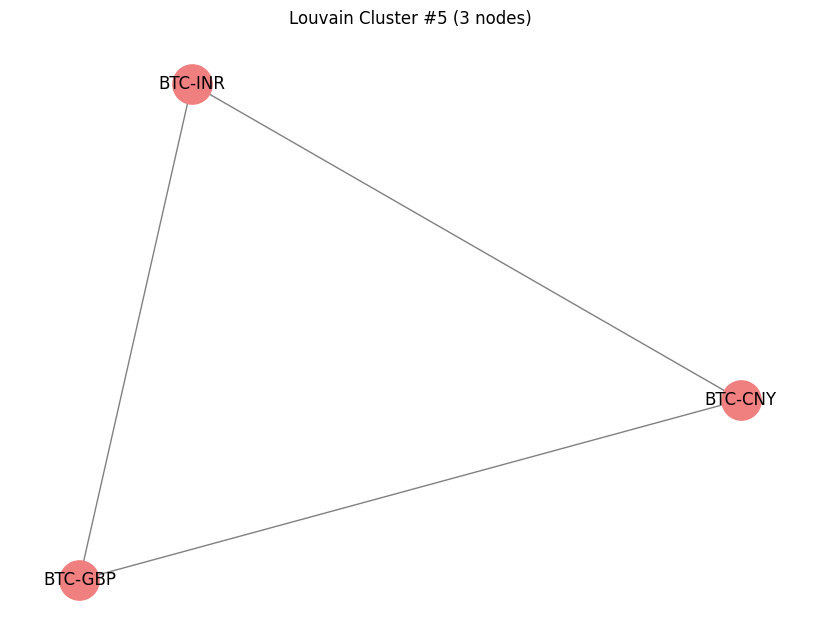

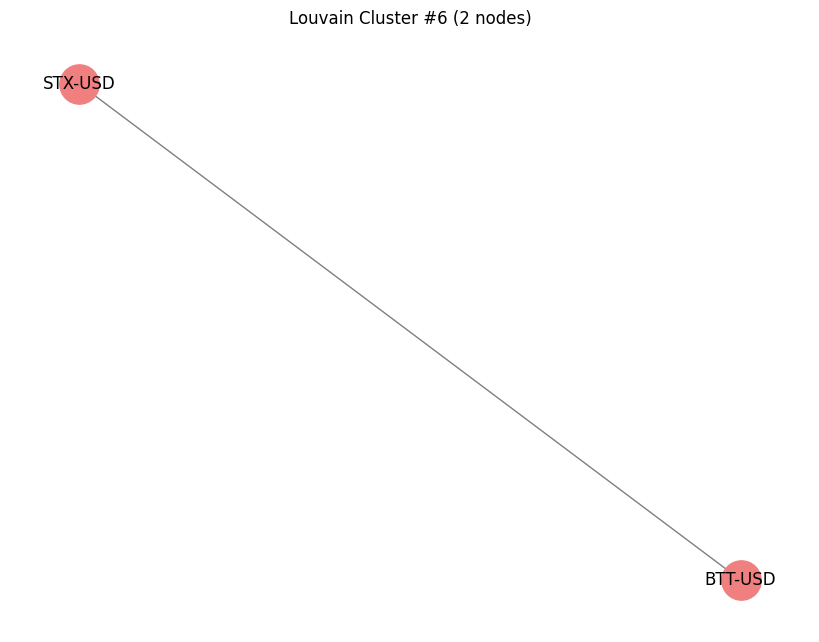

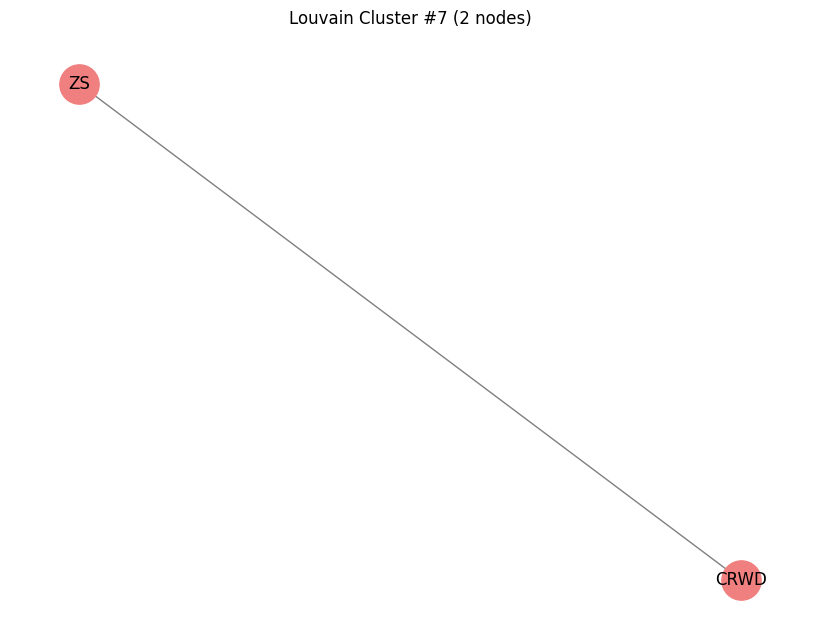

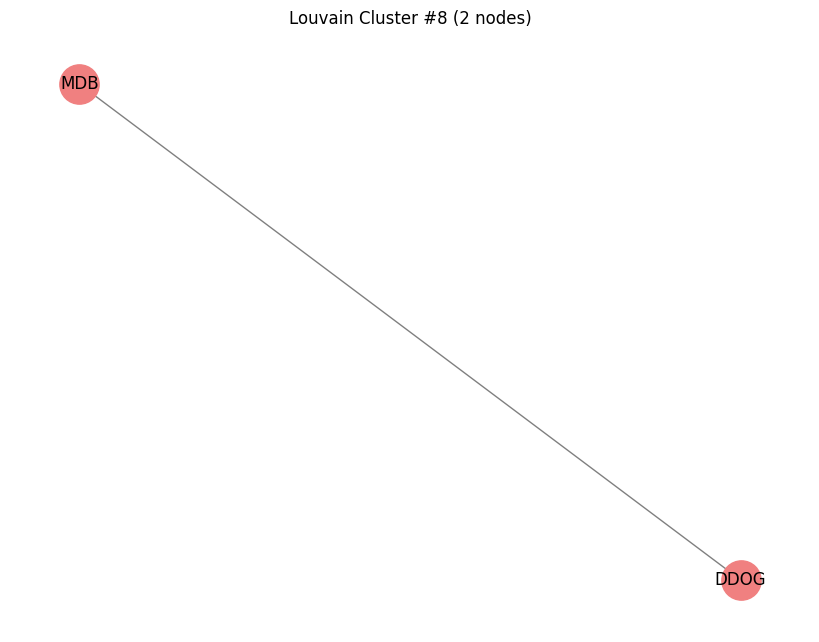

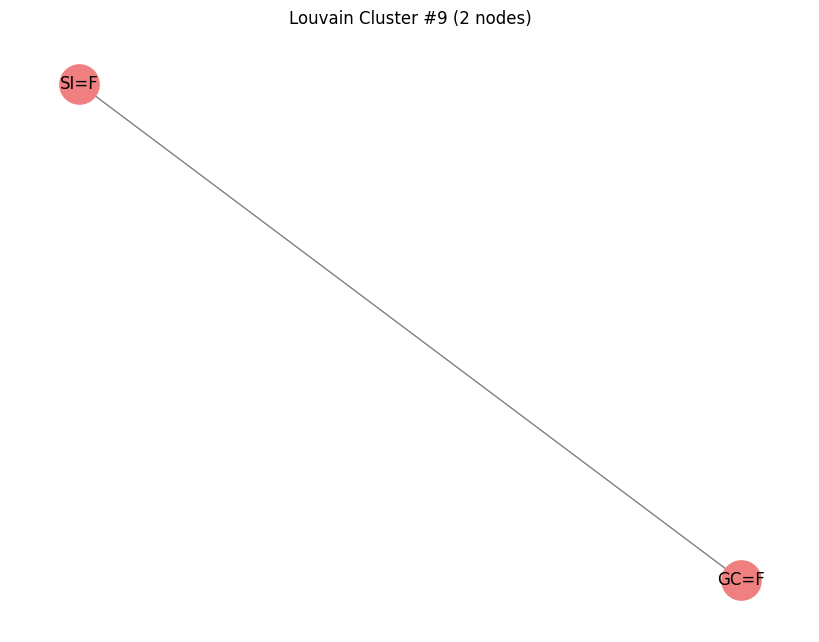

In [27]:
btc_cluster = cluster_louvain[cluster_louvain['ticker'] == 'BTC-USD']['cluster'].values[0]
peer_tickers = cluster_louvain[(cluster_louvain['cluster'] == btc_cluster) & 
                                (cluster_louvain['ticker'] != 'BTC-USD')]['ticker'].tolist()

# Filter and pivot
peer_df = data[data['ticker'].isin(peer_tickers)]
peer_prices = peer_df.pivot(index='date', columns='ticker', values='close').sort_index()


# Get all unique clusters
unique_clusters = cluster_louvain['cluster'].unique()

# Plot each cluster as a subgraph
for cluster_id in sorted(unique_clusters):
    tickers_in_cluster = cluster_louvain[cluster_louvain['cluster'] == cluster_id]['ticker'].tolist()
    subgraph = G.subgraph(tickers_in_cluster)

    # Skip clusters with only 1 node (no edges to draw)
    if len(subgraph.nodes) <= 1:
        continue

    pos = nx.spring_layout(subgraph, seed=42)
    plt.figure(figsize=(8, 6))
    nx.draw(subgraph, pos, with_labels=True,
            node_color='lightcoral', edge_color='gray', node_size=800)
    plt.title(f"Louvain Cluster #{cluster_id} ({len(subgraph.nodes)} nodes)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()




In [28]:
print (peer_tickers)

['ADA-USD', 'ETH-USD', 'LINK-USD', 'VET-USD', 'XLM-USD', 'ALGO-USD', 'ATOM-USD', 'XTZ-USD', 'BCH-USD', 'BSV-USD', 'EOS-USD', 'ETC-USD', 'LTC-USD', 'BNB-USD', 'CRO-USD', 'MKR-USD', 'NEXO-USD', 'ZEC-USD', 'XRP-USD']


### 🔮 LSTM Modeling for BTC Price Change Prediction

In this final stage, we build a **Long Short-Term Memory (LSTM)** neural network to predict short-term changes in BTC price based on historical prices of peer assets in the same Louvain cluster.

#### **Target Definition**
- We define the target as the **price delta**:  
  \[
  \text{target} = \text{close}(t+1) - \text{close}(t)
  \]
- This transforms the task into a **regression problem** predicting the next-period change in price.

#### **Input Features**
- We merge the BTC delta with **closing prices of peer assets**, creating a multivariate time series where each timestep includes correlated asset behavior.

#### **Preprocessing**
- Features and target values are scaled using `MinMaxScaler`.
- Data is reshaped into sequences of 60 timesteps (i.e., `time_step = 60`) to feed into the LSTM.

#### **Model Architecture**
- Two stacked LSTM layers for temporal pattern recognition.
- A dense layer with ReLU activation followed by a linear output layer for price delta prediction.

#### **Training Strategy**
- We use `EarlyStopping` to prevent overfitting, monitoring the loss with a patience of 5 epochs.

#### **Price Reconstruction**
- After predicting deltas, we **inverse transform** the predictions and **rebuild the actual price**:
  \[
  \text{predicted price}_{t+1} = \text{price}_t + \text{predicted delta}
  \]

#### **Performance Evaluation**
- Model performance is evaluated using:
  - **RMSE** (Root Mean Squared Error)
  - **MAE** (Mean Absolute Error)
  - **R² Score** (Explained variance)

This modeling approach captures short-term patterns in both BTC and its cluster peers, leveraging correlated market dynamics for improved forecasting accuracy.


In [29]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# ----- Prepare price delta as target -----
btc_df['target'] = btc_df['close'].shift(-1) - btc_df['close']
btc_features = btc_df.set_index('date')[['target']].dropna()

# Merge with peer prices
final_df = btc_features.join(peer_prices, how='inner').dropna()

# Feature/target split
feature_cols = final_df.columns.drop('target')
X = final_df[feature_cols].values
y = final_df['target'].values

# Scaling
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y.reshape(-1, 1))

# ----- Sequence builder -----
def create_sequences(X_data, y_data, time_step):
    X_seq, y_seq = [], []
    for i in range(len(X_data) - time_step):
        X_seq.append(X_data[i:i + time_step])
        y_seq.append(y_data[i + time_step - 1])  # predict delta for t+1
    return np.array(X_seq), np.array(y_seq)

time_step = 60
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_step)

# Split
split = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# ----- Model -----
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50),
    Dense(25, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=25, batch_size=32, callbacks=[early_stop])

# Evaluate
loss = model.evaluate(X_test, y_test)
print(f"✅ LSTM Test Loss (MSE): {loss:.4f}")

# ----- Inverse Transform & Rebuild Price -----
# Predict deltas (scaled -> real)
y_pred_scaled = model.predict(X_test)
y_pred_delta = target_scaler.inverse_transform(y_pred_scaled)
y_test_delta = target_scaler.inverse_transform(y_test.reshape(-1, 1))


btc_close = btc_df.set_index('date')['close']
btc_close = btc_close.loc[final_df.index]  # Match dates used in final_df
btc_close = btc_close.values[time_step - 1:]  # Align with LSTM shift
base_prices = btc_close[-len(y_test):]

y_pred_price = base_prices + y_pred_delta.flatten()
y_test_price = base_prices + y_test_delta.flatten()


# ----- Metrics -----
rmse = np.sqrt(mean_squared_error(y_test_price, y_pred_price))
mae = mean_absolute_error(y_test_price, y_pred_price)
r2 = r2_score(y_test_price, y_pred_price)

print(f"\n📉 RMSE (price): {rmse:.2f}")
print(f"📈 MAE (price): {mae:.2f}")
print(f"📊 R² Score (price): {r2:.4f}")


Epoch 1/25


I0000 00:00:1747603029.505349    3756 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 4s 14ms/step - loss: 0.0269
Epoch 2/25
48/48 [==============================] - 1s 13ms/step - loss: 0.0065
Epoch 3/25
48/48 [==============================] - 1s 13ms/step - loss: 0.0060
Epoch 4/25
48/48 [==============================] - 1s 13ms/step - loss: 0.0059
Epoch 5/25
48/48 [==============================] - 1s 14ms/step - loss: 0.0059
Epoch 6/25
48/48 [==============================] - 1s 12ms/step - loss: 0.0059
Epoch 7/25
48/48 [==============================] - 1s 14ms/step - loss: 0.0058
Epoch 8/25
48/48 [==============================] - 1s 15ms/step - loss: 0.0057
Epoch 9/25
48/48 [==============================] - 1s 15ms/step - loss: 0.0060
Epoch 10/25
48/48 [==============================] - 1s 16ms/step - loss: 0.0059
Epoch 11/25
48/48 [==============================] - 1s 15ms/step - loss: 0.0057
Epoch 12/25
48/48 [==============================] - 1s 15ms/step - loss: 0.0057
Epoch 13/25
48/48 [=============================

⚙️ Running SHAP KernelExplainer...
5/5 [==============================] - 0s 12ms/step


Using 150 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/150 [00:00<?, ?it/s]

469/469 [==============================] - 3s 6ms/step


  1%|          | 1/150 [00:03<08:56,  3.60s/it]

469/469 [==============================] - 3s 7ms/step


  1%|▏         | 2/150 [00:07<08:44,  3.55s/it]

469/469 [==============================] - 3s 7ms/step


  2%|▏         | 3/150 [00:10<08:43,  3.56s/it]

469/469 [==============================] - 3s 6ms/step


  3%|▎         | 4/150 [00:14<08:35,  3.53s/it]

469/469 [==============================] - 3s 7ms/step


  3%|▎         | 5/150 [00:17<08:32,  3.54s/it]

469/469 [==============================] - 3s 6ms/step


  4%|▍         | 6/150 [00:21<08:28,  3.53s/it]

469/469 [==============================] - 3s 7ms/step


  5%|▍         | 7/150 [00:24<08:22,  3.51s/it]

469/469 [==============================] - 3s 7ms/step


  5%|▌         | 8/150 [00:28<08:19,  3.52s/it]

469/469 [==============================] - 3s 7ms/step


  6%|▌         | 9/150 [00:31<08:16,  3.52s/it]

469/469 [==============================] - 3s 6ms/step


  7%|▋         | 10/150 [00:35<08:12,  3.52s/it]

469/469 [==============================] - 3s 7ms/step


  7%|▋         | 11/150 [00:38<08:11,  3.54s/it]

469/469 [==============================] - 3s 6ms/step


  8%|▊         | 12/150 [00:42<08:02,  3.50s/it]

469/469 [==============================] - 3s 7ms/step


  9%|▊         | 13/150 [00:45<08:00,  3.51s/it]

469/469 [==============================] - 3s 6ms/step


  9%|▉         | 14/150 [00:49<07:54,  3.49s/it]

469/469 [==============================] - 3s 6ms/step


 10%|█         | 15/150 [00:52<07:47,  3.47s/it]

469/469 [==============================] - 3s 6ms/step


 11%|█         | 16/150 [00:56<07:43,  3.46s/it]

469/469 [==============================] - 3s 6ms/step


 11%|█▏        | 17/150 [00:59<07:41,  3.47s/it]

469/469 [==============================] - 3s 6ms/step


 12%|█▏        | 18/150 [01:03<07:40,  3.49s/it]

469/469 [==============================] - 3s 7ms/step


 13%|█▎        | 19/150 [01:06<07:36,  3.48s/it]

469/469 [==============================] - 3s 7ms/step


 13%|█▎        | 20/150 [01:10<07:39,  3.54s/it]

469/469 [==============================] - 3s 6ms/step


 14%|█▍        | 21/150 [01:13<07:29,  3.48s/it]

469/469 [==============================] - 3s 6ms/step


 15%|█▍        | 22/150 [01:17<07:22,  3.46s/it]

469/469 [==============================] - 3s 6ms/step


 15%|█▌        | 23/150 [01:20<07:20,  3.47s/it]

469/469 [==============================] - 3s 6ms/step


 16%|█▌        | 24/150 [01:23<07:17,  3.47s/it]

469/469 [==============================] - 3s 6ms/step


 17%|█▋        | 25/150 [01:27<07:13,  3.46s/it]

469/469 [==============================] - 3s 7ms/step


 17%|█▋        | 26/150 [01:31<07:24,  3.59s/it]

469/469 [==============================] - 3s 6ms/step


 18%|█▊        | 27/150 [01:34<07:16,  3.55s/it]

469/469 [==============================] - 3s 7ms/step


 19%|█▊        | 28/150 [01:38<07:15,  3.57s/it]

469/469 [==============================] - 3s 7ms/step


 19%|█▉        | 29/150 [01:41<07:09,  3.55s/it]

469/469 [==============================] - 3s 6ms/step


 20%|██        | 30/150 [01:45<07:01,  3.51s/it]

469/469 [==============================] - 3s 6ms/step


 21%|██        | 31/150 [01:48<06:55,  3.49s/it]

469/469 [==============================] - 3s 6ms/step


 21%|██▏       | 32/150 [01:52<06:48,  3.46s/it]

469/469 [==============================] - 3s 7ms/step


 22%|██▏       | 33/150 [01:55<06:52,  3.52s/it]

469/469 [==============================] - 3s 6ms/step


 23%|██▎       | 34/150 [01:59<06:45,  3.50s/it]

469/469 [==============================] - 3s 7ms/step


 23%|██▎       | 35/150 [02:03<06:51,  3.58s/it]

469/469 [==============================] - 3s 7ms/step


 24%|██▍       | 36/150 [02:06<06:49,  3.59s/it]

469/469 [==============================] - 3s 7ms/step


 25%|██▍       | 37/150 [02:10<06:49,  3.62s/it]

469/469 [==============================] - 3s 7ms/step


 25%|██▌       | 38/150 [02:13<06:44,  3.61s/it]

469/469 [==============================] - 3s 7ms/step


 26%|██▌       | 39/150 [02:17<06:45,  3.65s/it]

469/469 [==============================] - 3s 6ms/step


 27%|██▋       | 40/150 [02:21<06:38,  3.62s/it]

469/469 [==============================] - 3s 7ms/step


 27%|██▋       | 41/150 [02:24<06:35,  3.63s/it]

469/469 [==============================] - 3s 7ms/step


 28%|██▊       | 42/150 [02:28<06:31,  3.62s/it]

469/469 [==============================] - 3s 6ms/step


 29%|██▊       | 43/150 [02:31<06:23,  3.59s/it]

469/469 [==============================] - 3s 7ms/step


 29%|██▉       | 44/150 [02:35<06:21,  3.60s/it]

469/469 [==============================] - 3s 6ms/step


 30%|███       | 45/150 [02:39<06:14,  3.56s/it]

469/469 [==============================] - 3s 6ms/step


 31%|███       | 46/150 [02:42<06:08,  3.54s/it]

469/469 [==============================] - 3s 6ms/step


 31%|███▏      | 47/150 [02:46<06:03,  3.53s/it]

469/469 [==============================] - 3s 6ms/step


 32%|███▏      | 48/150 [02:49<05:59,  3.52s/it]

469/469 [==============================] - 3s 7ms/step


 33%|███▎      | 49/150 [02:53<05:56,  3.53s/it]

469/469 [==============================] - 3s 7ms/step


 33%|███▎      | 50/150 [02:56<05:53,  3.54s/it]

469/469 [==============================] - 3s 6ms/step


 34%|███▍      | 51/150 [03:00<05:49,  3.53s/it]

469/469 [==============================] - 3s 7ms/step


 35%|███▍      | 52/150 [03:03<05:51,  3.59s/it]

469/469 [==============================] - 3s 6ms/step


 35%|███▌      | 53/150 [03:07<05:47,  3.58s/it]

469/469 [==============================] - 3s 7ms/step


 36%|███▌      | 54/150 [03:11<05:48,  3.63s/it]

469/469 [==============================] - 3s 6ms/step


 37%|███▋      | 55/150 [03:14<05:38,  3.56s/it]

469/469 [==============================] - 3s 7ms/step


 37%|███▋      | 56/150 [03:18<05:36,  3.58s/it]

469/469 [==============================] - 3s 6ms/step


 38%|███▊      | 57/150 [03:21<05:29,  3.54s/it]

469/469 [==============================] - 3s 6ms/step


 39%|███▊      | 58/150 [03:25<05:24,  3.53s/it]

469/469 [==============================] - 3s 7ms/step


 39%|███▉      | 59/150 [03:28<05:20,  3.53s/it]

469/469 [==============================] - 3s 7ms/step


 40%|████      | 60/150 [03:32<05:18,  3.54s/it]

469/469 [==============================] - 3s 7ms/step


 41%|████      | 61/150 [03:36<05:20,  3.61s/it]

469/469 [==============================] - 3s 7ms/step


 41%|████▏     | 62/150 [03:39<05:17,  3.61s/it]

469/469 [==============================] - 3s 7ms/step


 42%|████▏     | 63/150 [03:43<05:12,  3.59s/it]

469/469 [==============================] - 3s 6ms/step


 43%|████▎     | 64/150 [03:46<05:02,  3.52s/it]

469/469 [==============================] - 3s 6ms/step


 43%|████▎     | 65/150 [03:49<04:56,  3.48s/it]

469/469 [==============================] - 3s 7ms/step


 44%|████▍     | 66/150 [03:53<04:56,  3.52s/it]

469/469 [==============================] - 3s 6ms/step


 45%|████▍     | 67/150 [03:56<04:46,  3.46s/it]

469/469 [==============================] - 3s 7ms/step


 45%|████▌     | 68/150 [04:00<04:45,  3.49s/it]

469/469 [==============================] - 3s 7ms/step


 46%|████▌     | 69/150 [04:04<04:44,  3.51s/it]

469/469 [==============================] - 3s 6ms/step


 47%|████▋     | 70/150 [04:07<04:43,  3.55s/it]

469/469 [==============================] - 3s 6ms/step


 47%|████▋     | 71/150 [04:11<04:35,  3.49s/it]

469/469 [==============================] - 3s 7ms/step


 48%|████▊     | 72/150 [04:14<04:33,  3.50s/it]

469/469 [==============================] - 3s 7ms/step


 49%|████▊     | 73/150 [04:18<04:31,  3.53s/it]

469/469 [==============================] - 3s 6ms/step


 49%|████▉     | 74/150 [04:21<04:24,  3.48s/it]

469/469 [==============================] - 3s 6ms/step


 50%|█████     | 75/150 [04:24<04:19,  3.46s/it]

469/469 [==============================] - 3s 7ms/step


 51%|█████     | 76/150 [04:28<04:18,  3.49s/it]

469/469 [==============================] - 3s 6ms/step


 51%|█████▏    | 77/150 [04:31<04:15,  3.50s/it]

469/469 [==============================] - 3s 7ms/step


 52%|█████▏    | 78/150 [04:35<04:14,  3.53s/it]

469/469 [==============================] - 3s 7ms/step


 53%|█████▎    | 79/150 [04:39<04:12,  3.55s/it]

469/469 [==============================] - 3s 6ms/step


 53%|█████▎    | 80/150 [04:42<04:08,  3.55s/it]

469/469 [==============================] - 3s 7ms/step


 54%|█████▍    | 81/150 [04:46<04:04,  3.55s/it]

469/469 [==============================] - 3s 7ms/step


 55%|█████▍    | 82/150 [04:49<04:00,  3.54s/it]

469/469 [==============================] - 3s 6ms/step


 55%|█████▌    | 83/150 [04:53<03:57,  3.54s/it]

469/469 [==============================] - 3s 6ms/step


 56%|█████▌    | 84/150 [04:56<03:52,  3.52s/it]

469/469 [==============================] - 3s 7ms/step


 57%|█████▋    | 85/150 [05:00<03:52,  3.58s/it]

469/469 [==============================] - 3s 7ms/step


 57%|█████▋    | 86/150 [05:04<03:49,  3.58s/it]

469/469 [==============================] - 3s 7ms/step


 58%|█████▊    | 87/150 [05:07<03:46,  3.59s/it]

469/469 [==============================] - 3s 6ms/step


 59%|█████▊    | 88/150 [05:11<03:40,  3.56s/it]

469/469 [==============================] - 3s 7ms/step


 59%|█████▉    | 89/150 [05:14<03:37,  3.57s/it]

469/469 [==============================] - 3s 6ms/step


 60%|██████    | 90/150 [05:18<03:32,  3.54s/it]

469/469 [==============================] - 3s 7ms/step


 61%|██████    | 91/150 [05:21<03:29,  3.54s/it]

469/469 [==============================] - 3s 6ms/step


 61%|██████▏   | 92/150 [05:25<03:24,  3.52s/it]

469/469 [==============================] - 3s 6ms/step


 62%|██████▏   | 93/150 [05:28<03:20,  3.51s/it]

469/469 [==============================] - 3s 7ms/step


 63%|██████▎   | 94/150 [05:32<03:18,  3.54s/it]

469/469 [==============================] - 3s 7ms/step


 63%|██████▎   | 95/150 [05:36<03:17,  3.59s/it]

469/469 [==============================] - 3s 6ms/step


 64%|██████▍   | 96/150 [05:39<03:13,  3.58s/it]

469/469 [==============================] - 3s 7ms/step


 65%|██████▍   | 97/150 [05:43<03:10,  3.60s/it]

469/469 [==============================] - 3s 7ms/step


 65%|██████▌   | 98/150 [05:46<03:06,  3.59s/it]

469/469 [==============================] - 3s 6ms/step


 66%|██████▌   | 99/150 [05:50<03:01,  3.57s/it]

469/469 [==============================] - 3s 7ms/step


 67%|██████▋   | 100/150 [05:54<03:02,  3.65s/it]

469/469 [==============================] - 3s 6ms/step


 67%|██████▋   | 101/150 [05:57<02:56,  3.60s/it]

469/469 [==============================] - 3s 7ms/step


 68%|██████▊   | 102/150 [06:01<02:53,  3.61s/it]

469/469 [==============================] - 3s 6ms/step


 69%|██████▊   | 103/150 [06:04<02:46,  3.55s/it]

469/469 [==============================] - 3s 6ms/step


 69%|██████▉   | 104/150 [06:08<02:42,  3.54s/it]

469/469 [==============================] - 3s 7ms/step


 70%|███████   | 105/150 [06:11<02:39,  3.55s/it]

469/469 [==============================] - 3s 7ms/step


 71%|███████   | 106/150 [06:15<02:36,  3.57s/it]

469/469 [==============================] - 3s 7ms/step


 71%|███████▏  | 107/150 [06:19<02:34,  3.59s/it]

469/469 [==============================] - 3s 6ms/step


 72%|███████▏  | 108/150 [06:22<02:28,  3.53s/it]

469/469 [==============================] - 3s 6ms/step


 73%|███████▎  | 109/150 [06:25<02:22,  3.48s/it]

469/469 [==============================] - 3s 7ms/step


 73%|███████▎  | 110/150 [06:29<02:20,  3.52s/it]

469/469 [==============================] - 3s 7ms/step


 74%|███████▍  | 111/150 [06:33<02:19,  3.58s/it]

469/469 [==============================] - 3s 6ms/step


 75%|███████▍  | 112/150 [06:36<02:14,  3.54s/it]

469/469 [==============================] - 3s 7ms/step


 75%|███████▌  | 113/150 [06:40<02:11,  3.55s/it]

469/469 [==============================] - 3s 6ms/step


 76%|███████▌  | 114/150 [06:45<02:28,  4.14s/it]

469/469 [==============================] - 3s 7ms/step


 77%|███████▋  | 115/150 [06:49<02:20,  4.00s/it]

469/469 [==============================] - 3s 6ms/step


 77%|███████▋  | 116/150 [06:52<02:10,  3.83s/it]

469/469 [==============================] - 3s 7ms/step


 78%|███████▊  | 117/150 [06:56<02:05,  3.81s/it]

469/469 [==============================] - 3s 7ms/step


 79%|███████▊  | 118/150 [07:00<01:59,  3.73s/it]

469/469 [==============================] - 3s 6ms/step


 79%|███████▉  | 119/150 [07:03<01:54,  3.68s/it]

469/469 [==============================] - 3s 7ms/step


 80%|████████  | 120/150 [07:07<01:49,  3.64s/it]

469/469 [==============================] - 3s 6ms/step


 81%|████████  | 121/150 [07:10<01:42,  3.55s/it]

469/469 [==============================] - 3s 7ms/step


 81%|████████▏ | 122/150 [07:14<01:39,  3.55s/it]

469/469 [==============================] - 3s 6ms/step


 82%|████████▏ | 123/150 [07:17<01:36,  3.56s/it]

469/469 [==============================] - 3s 6ms/step


 83%|████████▎ | 124/150 [07:21<01:32,  3.55s/it]

469/469 [==============================] - 3s 7ms/step


 83%|████████▎ | 125/150 [07:24<01:29,  3.57s/it]

469/469 [==============================] - 3s 6ms/step


 84%|████████▍ | 126/150 [07:28<01:23,  3.47s/it]

469/469 [==============================] - 3s 6ms/step


 85%|████████▍ | 127/150 [07:31<01:18,  3.43s/it]

469/469 [==============================] - 3s 6ms/step


 85%|████████▌ | 128/150 [07:34<01:13,  3.35s/it]

469/469 [==============================] - 3s 7ms/step


 86%|████████▌ | 129/150 [07:38<01:11,  3.41s/it]

469/469 [==============================] - 3s 7ms/step


 87%|████████▋ | 130/150 [07:41<01:09,  3.46s/it]

469/469 [==============================] - 3s 7ms/step


 87%|████████▋ | 131/150 [07:45<01:06,  3.52s/it]

469/469 [==============================] - 3s 7ms/step


 88%|████████▊ | 132/150 [07:50<01:13,  4.10s/it]

469/469 [==============================] - 3s 7ms/step


 89%|████████▊ | 133/150 [07:54<01:07,  3.96s/it]

469/469 [==============================] - 3s 6ms/step


 89%|████████▉ | 134/150 [07:57<01:01,  3.82s/it]

469/469 [==============================] - 3s 6ms/step


 90%|█████████ | 135/150 [08:03<01:04,  4.33s/it]

469/469 [==============================] - 3s 7ms/step


 91%|█████████ | 136/150 [08:07<00:58,  4.20s/it]

469/469 [==============================] - 3s 6ms/step


 91%|█████████▏| 137/150 [08:10<00:51,  3.99s/it]

469/469 [==============================] - 3s 6ms/step


 92%|█████████▏| 138/150 [08:14<00:45,  3.78s/it]

469/469 [==============================] - 3s 6ms/step


 93%|█████████▎| 139/150 [08:17<00:39,  3.62s/it]

469/469 [==============================] - 3s 6ms/step


 93%|█████████▎| 140/150 [08:20<00:35,  3.54s/it]

469/469 [==============================] - 3s 6ms/step


 94%|█████████▍| 141/150 [08:24<00:31,  3.48s/it]

469/469 [==============================] - 3s 6ms/step


 95%|█████████▍| 142/150 [08:27<00:27,  3.38s/it]

469/469 [==============================] - 3s 7ms/step


 95%|█████████▌| 143/150 [08:30<00:24,  3.46s/it]

469/469 [==============================] - 3s 7ms/step


 96%|█████████▌| 144/150 [08:34<00:21,  3.56s/it]

469/469 [==============================] - 3s 6ms/step


 97%|█████████▋| 145/150 [08:38<00:17,  3.55s/it]

469/469 [==============================] - 3s 7ms/step


 97%|█████████▋| 146/150 [08:42<00:14,  3.62s/it]

469/469 [==============================] - 3s 6ms/step


 98%|█████████▊| 147/150 [08:45<00:10,  3.58s/it]

469/469 [==============================] - 3s 6ms/step


 99%|█████████▊| 148/150 [08:49<00:07,  3.57s/it]

469/469 [==============================] - 3s 6ms/step


 99%|█████████▉| 149/150 [08:52<00:03,  3.54s/it]

469/469 [==============================] - 3s 6ms/step


100%|██████████| 150/150 [08:56<00:00,  3.57s/it]

📊 Plotting SHAP summary and saving to shap_lstm_v1.png...


✅ SHAP summary plot saved.


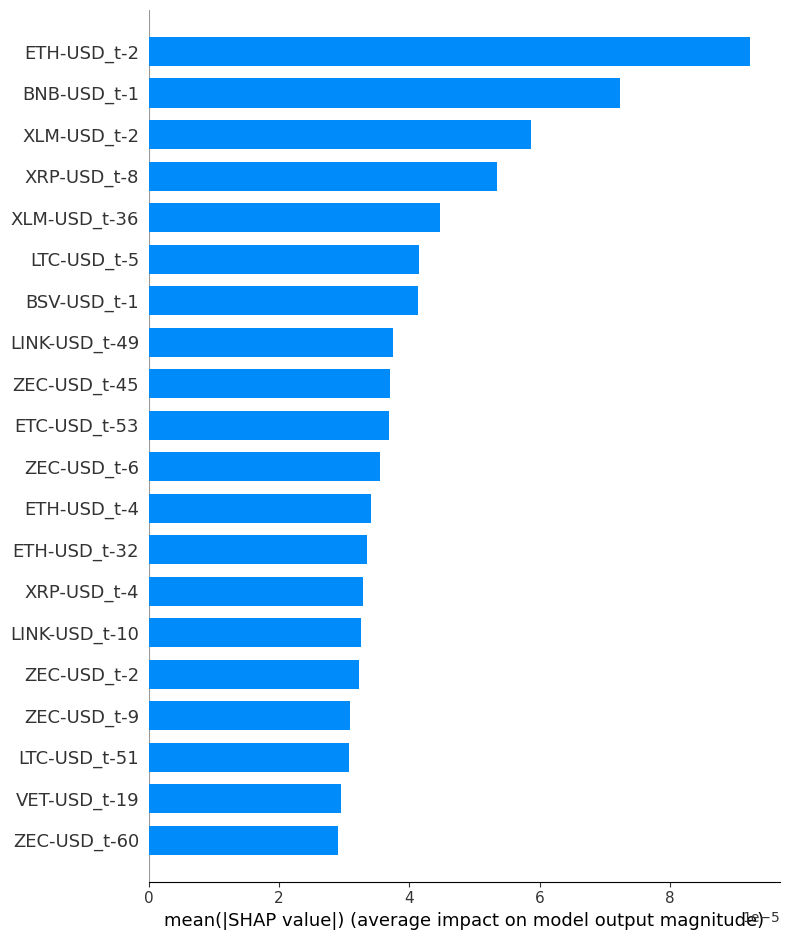

In [30]:
from utilities import explain_lstm_with_shap

explain_lstm_with_shap(
    model=model,
    X_train=X_train,
    X_test=X_test,
    feature_cols=feature_cols,  
    time_steps=60,
    background_size=150,
    sample_size=150,
    nsamples=100,
    plot_filename="shap_lstm_v1.png"
)




### 📊 Linear Regression Baseline Model (BTC + Cluster Peers)

To provide a baseline comparison against the LSTM model, we train a **Linear Regression** model using a combination of **technical indicators** and **cluster peer prices**.

#### **Feature Set**
- **BTC-specific technical indicators**:
  - Momentum: `MACD`, `MACD_Diff`, `RSI`, `MFI`, `Stochastic`
  - Trend: `EMA_Short`, `EMA_Long`, `SAR`
  - Volatility: `Bollinger_Upper`, `Bollinger_Lower`
- **Peer prices**: Closing prices of assets from BTC's Louvain cluster.

#### **Target Variable**
- The model predicts the **next-period closing price** of BTC (`close(t+1)`), making it a direct forecasting model rather than delta-based.

#### **Model Pipeline**
- A `Pipeline` is built with:
  - **StandardScaler**: Standardizes feature ranges (mean=0, std=1).
  - **LinearRegression**: A fast, interpretable, and robust model for continuous prediction.

#### **Train-Test Strategy**
- Data is split **chronologically** (no shuffling) to preserve temporal order and prevent look-ahead bias.

#### **Performance Metrics**
- **R² Score**: Proportion of variance explained by the model.
- **RMSE**: Root Mean Squared Error — interpretable in price units.

> ⚖️ This linear model serves as a **benchmark** to compare against more complex models (e.g., LSTM). While simpler, it provides quick insight into how much predictive power is embedded in technical + peer signals.


In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

# Prep BTC-only dataframe
btc_lregression = btc_df.copy()
btc_lregression['target'] = btc_lregression['close'].shift(-1)

# Keep only TA indicators + target
btc_features = btc_lregression.set_index('date')[[
    'MACD', 'MACD_Diff', 'RSI', 'MFI', 'EMA_Short', 'EMA_Long',
    'Bollinger_Upper', 'Bollinger_Lower', 'Stochastic', 'SAR', 'target'
]].dropna()

# Join peer prices (cluster tickers)
final_lregression = btc_features.join(peer_prices, how='inner').dropna()

# Features & Target
X = final_lregression.drop(columns='target')
y = final_lregression['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Build pipeline: Standardization + LinearRegression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

# Train model
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

# Evaluate
print("✅ R² score:", r2_score(y_test, y_pred))
print("📉 RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))



✅ R² score: 0.9717490409914857
📉 RMSE: 2711.816883487389


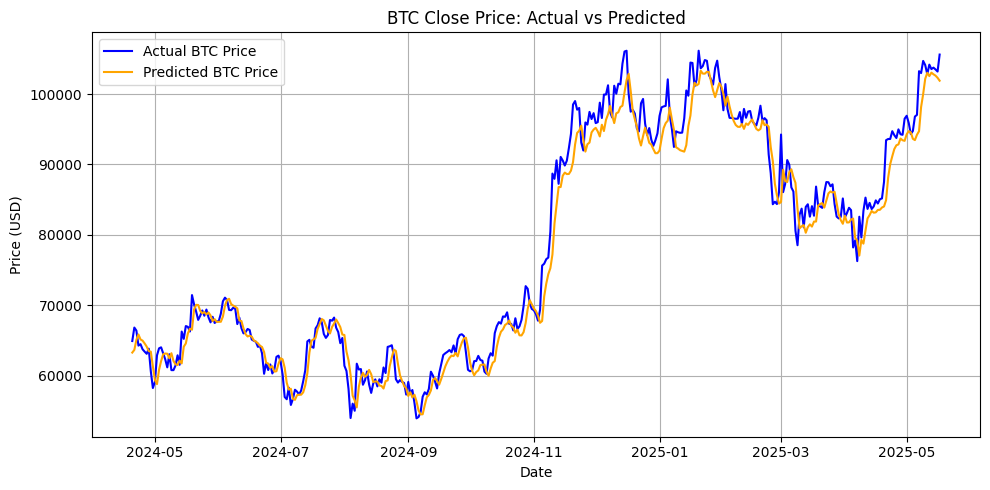

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Actual BTC Price", color='blue')
plt.plot(y_test.index, y_pred, label="Predicted BTC Price", color='orange')
plt.title("BTC Close Price: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


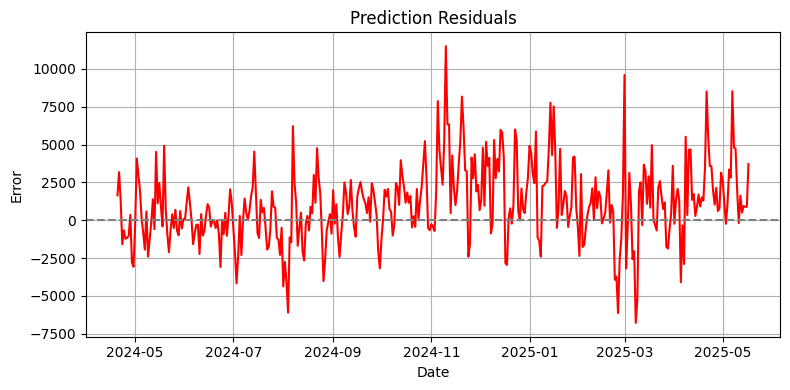

In [33]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 4))
plt.plot(y_test.index, residuals, label='Residuals (Actual - Predicted)', color='red')
plt.axhline(0, linestyle='--', color='gray')
plt.title("Prediction Residuals")
plt.xlabel("Date")
plt.ylabel("Error")
plt.grid(True)
plt.tight_layout()
plt.show()


### 🧮 Residual Analysis: Linear Regression Model

To further evaluate model performance and potential bias, we plot the **residuals** of the Linear Regression model:

\[
\text{Residual} = \text{Actual Price} - \text{Predicted Price}
\]

#### **Visualization**
- A **histogram with KDE (Kernel Density Estimation)** is plotted to visualize the distribution of prediction errors.
- A vertical dashed line at 0 helps assess the model’s bias:
  - Symmetric distribution centered around zero suggests **unbiased predictions**.
  - Skewed distribution may indicate **systematic over/underestimation**.

#### **Interpretation**
- Ideally, residuals should be:
  - **Randomly distributed**, indicating a good model fit.
  - **Low in variance**, which correlates with lower RMSE.

> 📌 This plot is a valuable diagnostic tool for identifying prediction anomalies and understanding how well the linear model captures underlying price behavior.


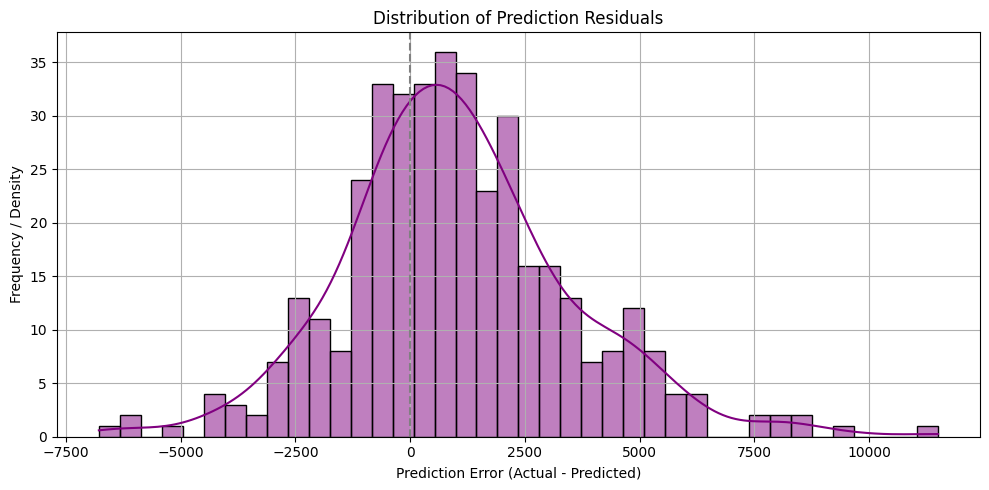

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Residuals
residuals = y_test - y_pred

# Plot histogram + KDE
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, bins=40, color='purple')
plt.axvline(0, linestyle='--', color='gray')
plt.title("Distribution of Prediction Residuals")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency / Density")
plt.grid(True)
plt.tight_layout()
plt.show()


### 📋 OLS Model Summary (Statsmodels)

To gain deeper insight into the statistical significance and contribution of each feature, we fit an **Ordinary Least Squares (OLS)** regression using the `statsmodels` library.

#### **Key Features**
- **Manual Intercept**: A constant term is explicitly added to the feature set (required by `statsmodels`).
- **OLS Fit**: The model estimates coefficients by minimizing the residual sum of squares.
- **Detailed Summary Output** includes:
  - **Coefficients** for each predictor (positive or negative influence)
  - **t-statistics** and **p-values** to assess statistical significance
  - **R² and adjusted R²**: Goodness-of-fit metrics
  - **Durbin-Watson statistic**: Checks for autocorrelation in residuals
  - **F-statistic**: Global significance of the model
  - **Condition number**: Diagnoses multicollinearity

#### **Interpretation Tips**
- Features with **low p-values (< 0.05)** are typically considered significant contributors to the model.
- A **high R²** and **low standard errors** suggest the model captures meaningful relationships.
- Watch for **high condition number** or **very large standard errors** as indicators of multicollinearity or overfitting.

> 📌 This step bridges machine learning with classical statistics, offering transparency into how each feature affects BTC price forecasting.


In [35]:
import statsmodels.api as sm

# Add intercept manually (statsmodels doesn't do it by default)
X_sm = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X_sm).fit()

# Show summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.721e+04
Date:                Sun, 18 May 2025   Prob (F-statistic):               0.00
Time:                        21:26:22   Log-Likelihood:                -17257.
No. Observations:                1964   AIC:                         3.457e+04
Df Residuals:                    1935   BIC:                         3.473e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1391.6770    337.065     

### 🧪 Feature Selection & Reduced Linear Model

To enhance interpretability and reduce noise, we retrain the Linear Regression model using only the **statistically significant features** identified by the previous OLS analysis.

#### **Feature Selection**
- We filter features with **p-values < 0.05** based on the OLS summary.
- The intercept is excluded when constructing the reduced feature matrix.
- This step improves model generalization by focusing only on meaningful predictors.

#### **Pipeline (Reduced Features)**
- The same `Pipeline` structure is reused:
  - `StandardScaler` to standardize inputs
  - `LinearRegression` as the prediction model
- The model is retrained and evaluated using the reduced feature set.

#### **Performance Metrics**
- **R² Score** and **RMSE** are computed to assess model performance after reduction.
- A **residual plot** is generated to visually inspect the quality of predictions:
  - Ideally centered around zero
  - Indicates whether the reduced model introduces any new bias

#### ✅ Benefits of Feature Reduction:
- Improves **interpretability** and **explainability**
- Reduces **model complexity** and risk of overfitting
- Allows focus on the most **economically relevant signals**

> 📌 This step showcases how combining statistical testing with machine learning can yield more robust and transparent predictive models.


✅ R² score (reduced): 0.9785928210433212
📉 RMSE (reduced): 2360.605869299714
📊 MAE  (reduced): 1790.1963771707176


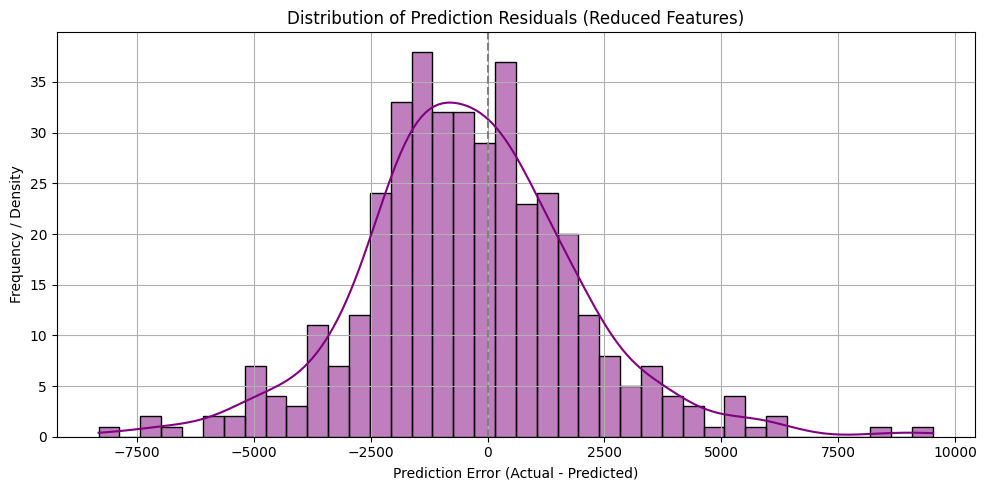

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error

# Select significant features (excluding intercept)
significant_features = model.pvalues[model.pvalues < 0.05].index.tolist()
X_reduced = X[significant_features[1:]]  # Exclude intercept if present

# Build reduced pipeline
pipeline_reduced = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

# Train model with reduced features
pipeline_reduced.fit(X_train[X_reduced.columns], y_train)

# Predict with reduced features
y_pred_reduced = pipeline_reduced.predict(X_test[X_reduced.columns])

# Evaluate
print("✅ R² score (reduced):", r2_score(y_test, y_pred_reduced))
print("📉 RMSE (reduced):", np.sqrt(mean_squared_error(y_test, y_pred_reduced)))
print("📊 MAE  (reduced):", mean_absolute_error(y_test, y_pred_reduced))

# Residuals
residuals = y_test - y_pred_reduced

# Plot histogram + KDE
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, bins=40, color='purple')
plt.axvline(0, linestyle='--', color='gray')
plt.title("Distribution of Prediction Residuals (Reduced Features)")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency / Density")
plt.grid(True)
plt.tight_layout()
plt.show()




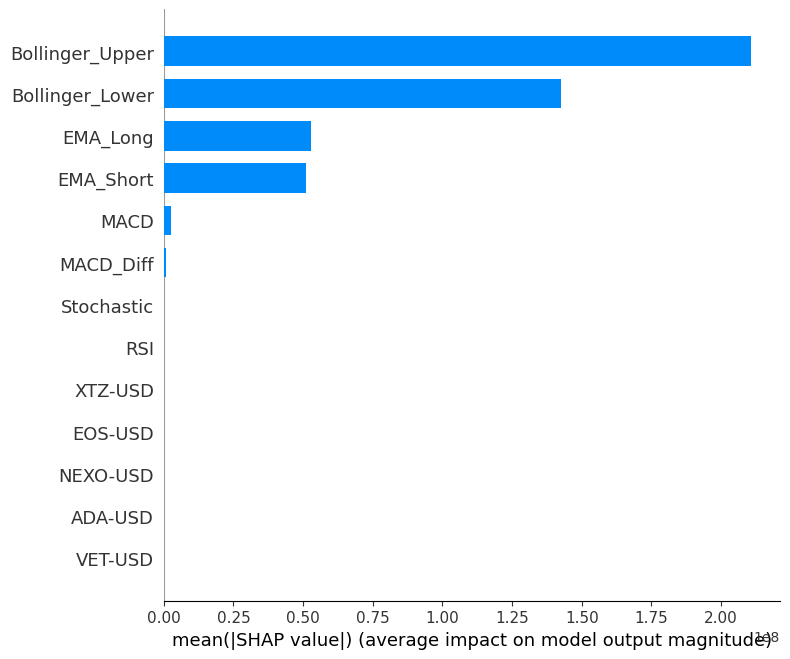

In [37]:
import shap
import numpy as np

# SHAP for linear regression
explainer_lr = shap.Explainer(pipeline_reduced.named_steps['lr'], X_test[X_reduced.columns], feature_perturbation="interventional")
shap_values_lr = explainer_lr(X_test[X_reduced.columns])

# Summary plot
shap.summary_plot(shap_values_lr, X_test[X_reduced.columns], plot_type="bar")


In [38]:
residuals_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_reduced,
    'Residual': residuals
})

# Filter rows with absolute residual > 7000
significant_errors = residuals_df[np.abs(residuals_df['Residual']) > 7000]

# Show them
print("🔍 Residuals with absolute error > $7,000:")
print(significant_errors.sort_values(by='Residual', key=abs, ascending=False))

🔍 Residuals with absolute error > $7,000:
                  Actual     Predicted     Residual
date                                               
2024-11-10  88701.484375  79171.599761  9529.884614
2025-03-01  94248.351562  85684.838106  8563.513456
2025-03-08  80601.039062  88920.502871 -8319.463809
2025-02-25  84347.023438  91529.173525 -7182.150088
2025-03-09  78532.000000  85564.529726 -7032.529726


### 🧾 Conclusion

- Louvain clustering revealed meaningful asset communities based on return correlations.
- LSTM outperformed linear regression in capturing short-term BTC price deltas, leveraging peer influence.
- Statistically significant features from OLS improved interpretability and simplified the linear model without major accuracy loss.
